# imports

In [1]:
from notebooks_tools import *
%matplotlib inline

# load MC tracks

In [4]:
# data = pd.read_csv('/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/FeaturesFiles/features_MC_BNB_AnalysisTrees.csv')
# data_protons = data[data.MCpdgCode==2212]
# data_nonprotons = data[data.MCpdgCode!=2212]
MCBNB_gen_protons = pd.read_csv('/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/FeaturesFiles/g4_features_MC_BNB_AnalysisTrees.csv')
MCBNB_gen_protons = MCBNB_gen_protons[(MCBNB_gen_protons.pdg==2212) & (MCBNB_gen_protons.primary==1)]
MCBNB_gen_muons = MCBNB_gen_protons[(np.abs(MCBNB_gen_protons.pdg)==13) & (MCBNB_gen_protons.primary==1)]
MCBNB_gen_protons['KE'] = MCBNB_gen_protons.Eng - 0.9383
MCBNB_rec_protons = pd.read_csv('/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/FeaturesFiles/full_features_MC_BNB_AnalysisTrees.csv')
MCBNB_rec_protons = MCBNB_rec_protons[(MCBNB_rec_protons.MCpdgCode==2212)  & (MCBNB_rec_protons.process_primary==1)]
MCBNB_gen_muons = MCBNB_gen_protons[(np.abs(MCBNB_gen_protons.pdg)==13) & (MCBNB_gen_protons.primary==1)]
MCBNB_rec_protons['truth_KE'] = MCBNB_rec_protons.truth_Eng - 0.9383

In [64]:
len(MCBNB_gen_protons),len(MCBNB_rec_protons)

(1179175, 115305)

In [52]:
def acceptace_1d( var='P', x_label='momentum [GeV/c]',
                 bins=np.linspace(0,2,30) ,
                 figsize=(10,10),fontsize=20,
                legend_loc='lower left',
                y_lim=None):
    x = [bins[i] for i in range(len(bins)-1)]

    fig = plt.figure(figsize=figsize)
    ax=fig.add_subplot(211)
    h_gen,edges=np.histogram(MCBNB_gen_protons[var],bins=bins)
    h_gen_err = np.sqrt(h_gen)
    h_rec,edges=np.histogram(MCBNB_rec_protons['truth_'+var],bins=bins)
    h_rec_err = np.sqrt(h_rec)
    plt.errorbar(x, h_gen, yerr=h_gen_err, fmt='o',markersize=4,label='generated')
    plt.errorbar(x, h_rec, yerr=h_rec_err, fmt='s',markersize=4,label='reconstructed')

    plt.legend(fontsize=fontsize,loc=legend_loc)
    set_axes(ax,'','')
    acceptance = [float(h_rec[i])/h_gen[i] if h_gen[i]>0 else 0 for i in range(len(h_gen))]
    acceptance_err = [sqrt(1./h_rec[i]+1./h_gen[i]) if h_gen[i]>50 and h_rec[i]>50 else 0 for i in range(len(h_gen))]

    ax=fig.add_subplot(212)
    plt.errorbar(x, acceptance, yerr=acceptance_err, fmt='o',label='Reconstructed proton tracks')
    plt.plot(x,acceptance,color='r',marker='s')
    if y_lim is None:
        ax.set_ylim(0,np.max([1.,1.2*np.max(acceptance+acceptance_err)]))
    else:
        ax.set_ylim(y_lim)
    set_axes(ax,x_label,'fraction of true protons')
    
def acceptace_2d( vx='theta' , vy='phi', 
                 x_label='$\\theta$ [rad.]',y_label='$\\phi$ [rad.]',
                 binsx=np.linspace(0,3.4,30) , binsy=np.linspace(-3.4,3.4,30),
                 figsize=(10,10),fontsize=20,
                legend_loc='lower left',
                norm=LogNorm()):
    x = [binsx[i] for i in range(len(binsx)-1)]
    y = [binsy[i] for i in range(len(binsy)-1)]

    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(131)
    h_gen,xedges,yedges = np.histogram2d(MCBNB_gen_protons[vx],MCBNB_gen_protons[vy],bins=[binsx,binsy])
    h_rec,xedges,yedges = np.histogram2d(MCBNB_rec_protons['truth_'+vx],MCBNB_rec_protons['truth_'+vy],bins=[binsx,binsy])
    plt.scatter(MCBNB_gen_protons[vx],MCBNB_gen_protons[vy],s=7,color='black',label='generated')
    plt.scatter(MCBNB_rec_protons['truth_'+vx],MCBNB_rec_protons['truth_'+vy],s=4,color='green',label='reconstructed')
    ax = fig.add_subplot(132)
    plt.hist2d(MCBNB_gen_protons[vx],MCBNB_gen_protons[vy],bins=[binsx,binsy],cmap='gray_r')
    ax.set_title('generated')
    plt.colorbar()
    ax = fig.add_subplot(133)
    plt.hist2d(MCBNB_rec_protons['truth_'+vx],MCBNB_rec_protons['truth_'+vy],bins=[binsx,binsy],cmap='Greens')
    ax.set_title('reconstructed')
    plt.colorbar()
    fig,ax = plt.subplots(figsize=figsize)
    acceptance = np.zeros([len(binsx)-1,len(binsy)-1])
    for i in range(len(binsx)-1):
        for j in range(len(binsy)-1):
            if h_gen[i][j]>0 and h_gen[i][j]>h_rec[i][j]:
                acceptance[i][j] = float(h_rec[i][j])/h_gen[i][j]            
            elif h_rec[i][j]>h_gen[i][j]:
                acceptance[i][j] = 1
            elif h_gen[i][j]==0: 
                acceptance[i][j] = 0

    X, Y = np.meshgrid(xedges, yedges)
    quadmesh = ax.pcolormesh(X, Y, acceptance.T,cmap='hot_r')#,norm=norm)
    cb = plt.colorbar(quadmesh) 
    for l in cb.ax.yaxis.get_ticklabels():
        l.set_fontsize(fontsize)
    ax.set_xlim(np.min(binsx),np.max(binsx))
    ax.set_ylim(np.min(binsy),np.max(binsy))
    set_axes(ax,x_label,y_label)
    return X , Y , acceptance

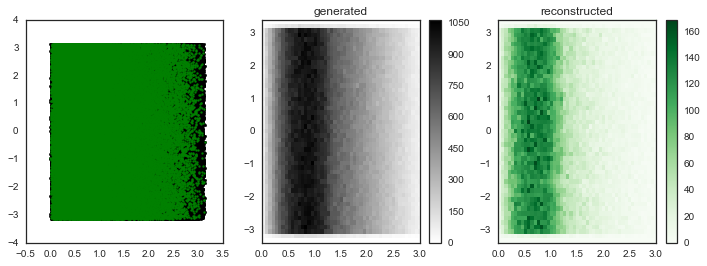

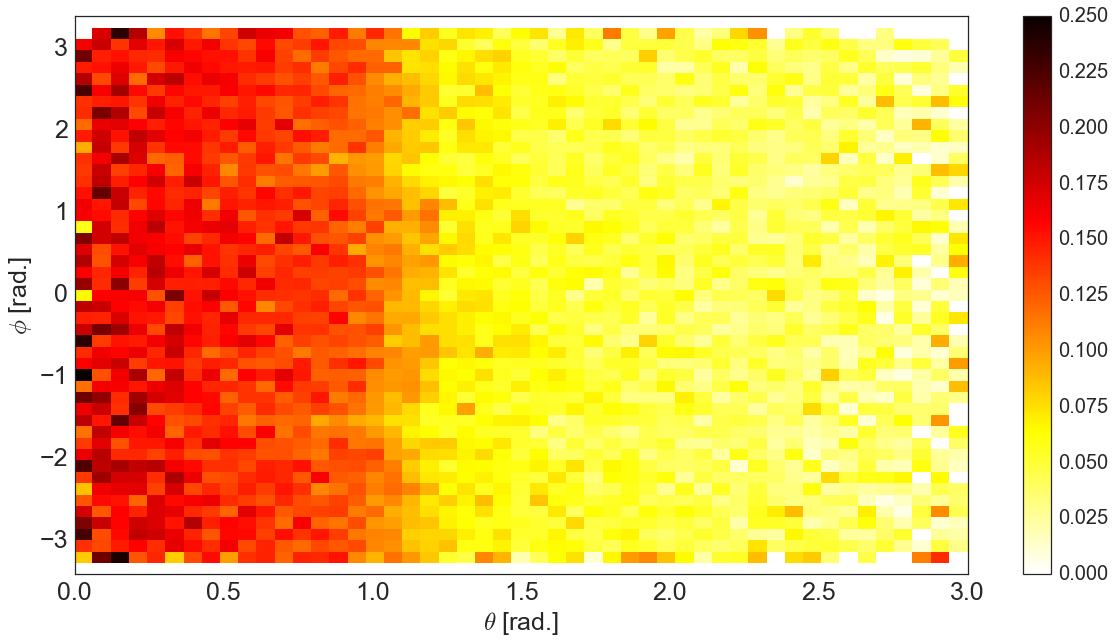

In [50]:
X , Y , acceptance = acceptace_2d( vx='theta' , vy='phi',binsx=np.linspace(0,3.,50) , binsy=np.linspace(-3.4,3.4,50), norm=None,figsize=(20,10))

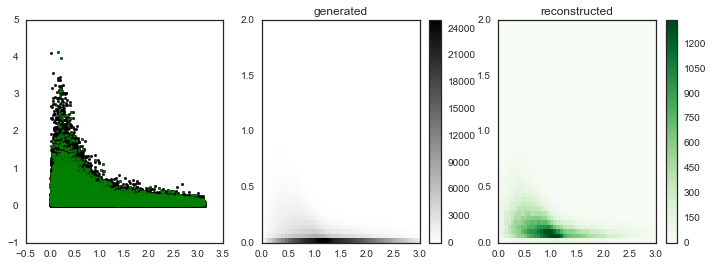

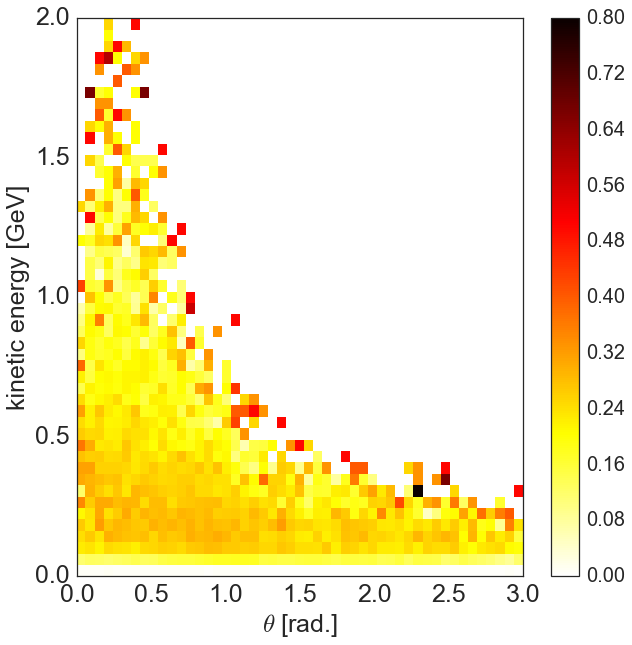

In [61]:
X , Y , acceptance = acceptace_2d( vx='theta' , vy='KE',binsx=np.linspace(0,3.,50) , binsy=np.linspace(0,2.,50) ,y_label='kinetic energy [GeV]' )

In [16]:
bins = np.linspace(0,50,50)
plt.hist(data_protons.pidpida[data_protons.pidpida<100],bins=bins,color='blue',histtype='step',label='MC protons')
plt.hist(data_nonprotons.pidpida[data_nonprotons.pidpida<100],bins=bins,color='green',histtype='step',label='MC non protons')
plt.legend()

NameError: name 'data_protons' is not defined

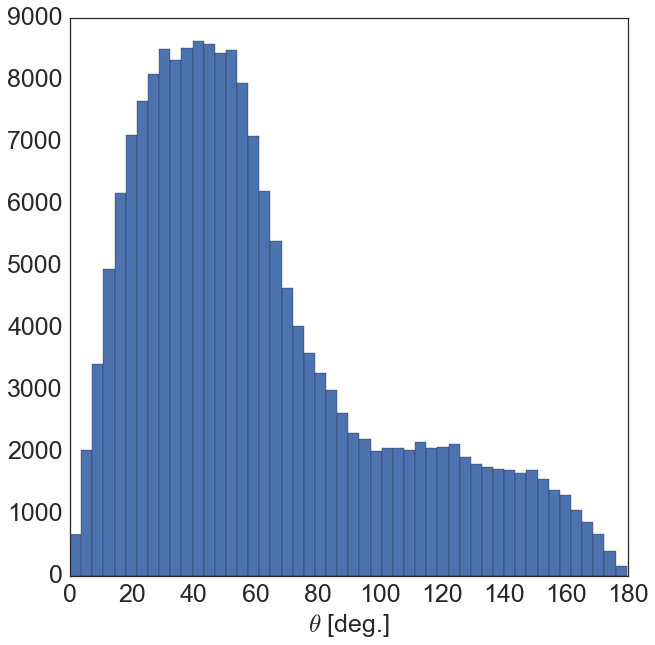

In [10]:
pt.plot_1d_hist(180/3.1415*data_protons.theta,bins=50,histtype='bar',xlabel='$\\theta$ [deg.]')

In [ ]:
pt.plot_2d_hist(180/3.1415*data_protons.theta,data_protons.Ev_truth,xlabel='$\\theta$ [deg.]',ylabel='truth $\\E_{\\nu}$ [MeV]')

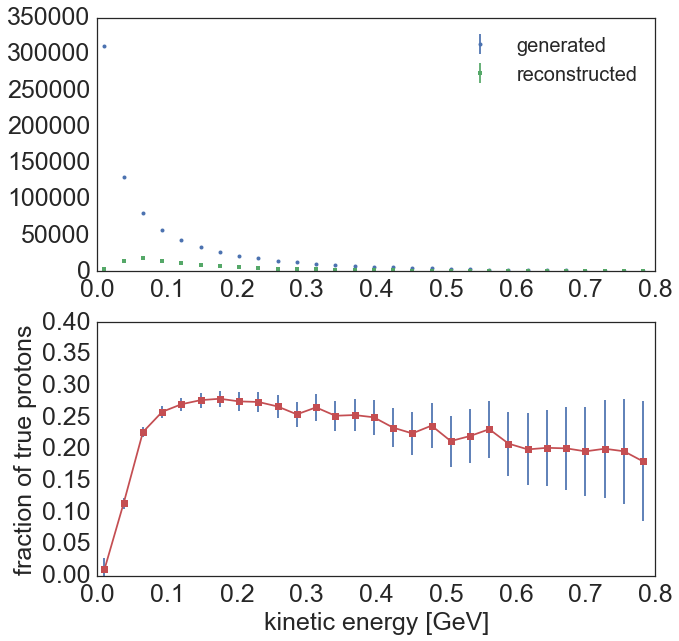

In [54]:
acceptace_1d( var='KE', x_label='kinetic energy [GeV]', bins=np.linspace(0.01,0.81,30),legend_loc='upper right',y_lim=(0,0.4) )

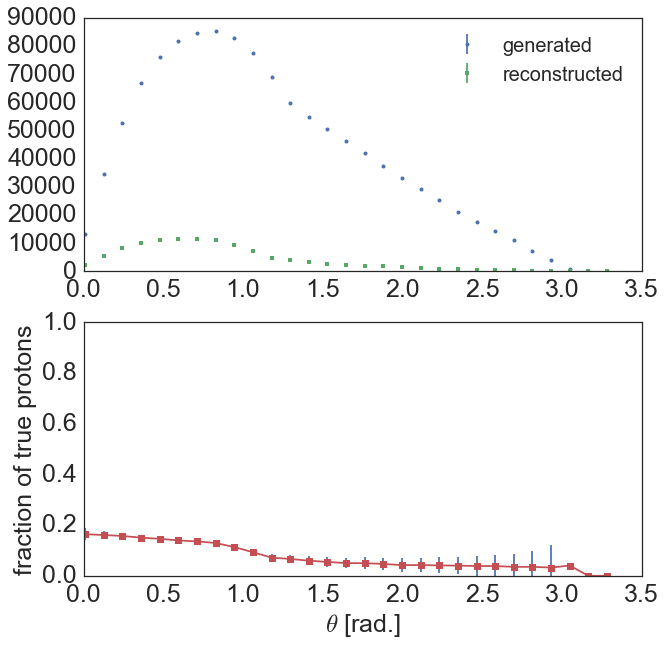

In [62]:
acceptace_1d( var='theta', x_label='$\\theta$ [rad.]', bins=np.linspace(0.01,3.4,30),legend_loc='upper right' )

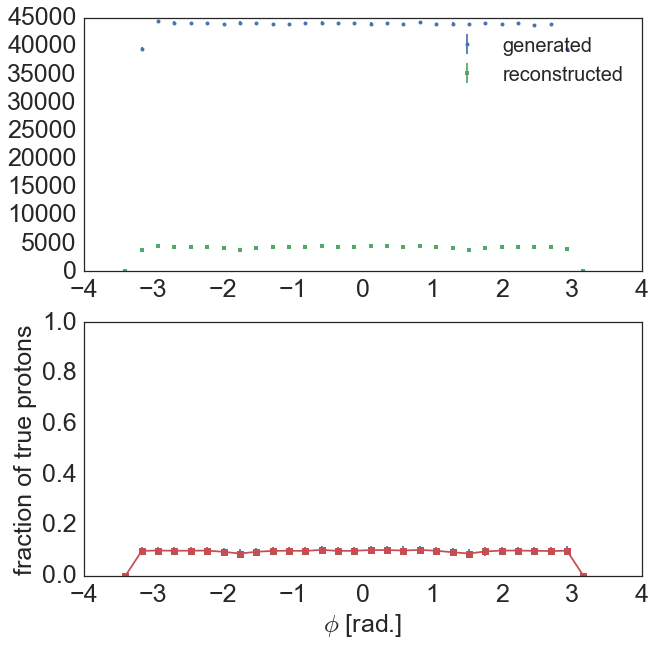

In [63]:
acceptace_1d( var='phi', x_label='$\\phi$ [rad.]', bins=np.linspace(-3.4,3.4,30),legend_loc='upper right' )